# TensorFlow & Multivariate Analysis

## Using the ACS Flo-thru data, model a predicted output.

In [5]:
# Python 3.7.3
############################################
# INCLUDES
############################################
#libraries specific to this example
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# seed the pseudorandom number generator
from random import seed
from random import random
from random import randint

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import types

#Data Science Libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage

#Plotting libraries
import matplotlib as matplt
import matplotlib.pyplot as plt

# can type in the python console `help(name of function)` to get the documentation
from pydoc import help                          


#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

#Import a custom library, in this case a fairly useful logging framework
if os.environ.get('LIB_LOCATION') is not None:
    debug_lib_location = Path(os.getenv('LIB_LOCATION'))
else:
    debug_lib_location = Path("./")
                              
if os.environ.get('DATA_LOCATION') is not None:
    root_location = os.getenv('DATA_LOCATION')
else:
    root_location=".." + os.sep + "data";             

sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


2022-12-14 21:53:37.302591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [7]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1                            #General ledger output so you know what's happening.
DEBUG_DATA = 1                       #Extremely verbose output, change to zero (0) to supress the volume of output.

# CODE CONSTRAINTS
VERSION_NAME    = "MachineLearning"
VERSION_ACRONYM = "ML-ACS"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = "0b"
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."

ENCODING  ="utf-8"
############################################
# GLOBAL CONSTANTS
############################################
TEST_DISTRIBUTION_PERCENT=0.2
# Model constants
MDL_DIMS                 = 1                 #vars used as inputs
#MDL_1ST_LYR_NEURONS      = 8096              #number of neurons used to process the inputs
MDL_1ST_LYR_NEURONS      = 1024
MDL_1ST_LYR_ACTIVATION   = tf.nn.relu        #('relu') activation function used to adjust probabilities going forward to the next neuron
MDL_LOSS                 ='mse'              #loss function (mean standard error)
#MDL_OPTIMIZER            ='adam'             #optimizer
MDL_OPTIMIZER            = tf.keras.optimizers.Adam(0.01)
MDL_METRICS              ='accuracy'         #metrics to gather during execution of the neural model

MDL_DENSE_NEURONS        = 35                #number of output vars
MDL_DENSE_ACTIVATION     = tf.nn.sigmoid     #('sigmoid') activation function used to make the final determination in the output layer

MDL_EPOCS                = 100               #number of times the training set will be iterated against
MDL_BATCH_SZ             = 100               #number of records to process as the training commences

############################################
# APPLICATION VARIABLES
############################################

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


## General Function Declaration

In [8]:
############################################
# WARNING / ERROR Management
############################################
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


############################################
# FUNCTIONS
############################################

def prototype(incMonth):

    debug.msg_info("Entering {}.{}".format(__name__, inspect.stack()[0][3]))
    debug.msg_info("The month you passed in was " + str(incMonth))
    debug.msg_info("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return 1

def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    try:
        netcdf4_version_info = nc.getlibversion().split(" ")
        debug.msg_debug("netCDF4 version   #:{:>12}".format(netcdf4_version_info[0]))
    except:
        print("NetCDF4 lib not present.")
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("SciPy version     #:{:>12}".format(sp.__version__))
    debug.msg_debug("TensorFlow version#:{:>12}".format(tf.__version__))
    return

def get_full_version():

    resultant = str(VERSION_NAME) + "  v" + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def get_version():

    resultant = str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def printversion():

    print(get_full_version())

def printusage():

    print("")
    printversion()
    print("  -v, --version    prints the version of this software package.")
    print("")
    print("  * - indicates required argument.")

######################################################################
#Support routines to see columns in DataFrames
######################################################################
def show_columns_plain(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(np.char.lower(col))
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def show_columns_true(inc_ary):
    new_ary = []
    for col in inc_ary:
        new_ary.append(col)
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

######################################################################
#Input Validation
######################################################################
# valid string:
#  We don't want the following:
#   - at the start of the file name (might be construed as a switch)
#  $, &, |, ;, <, >, `, !, *, ", \ (to start with)
###
def validstring(testsubject):

    if testsubject[0] == "-":
        return 0
    elif "$" in testsubject or "&" in testsubject or "|" in testsubject:
        return 0
    elif ";" in testsubject or "`" in testsubject or "!" in testsubject:
        return 0
    elif "*" in testsubject or '"' in testsubject or "\\" in testsubject:
        return 0
    else:
        return 1
    
######################################################################
#Machine Learning - Save the model when the patience function fires
######################################################################
def save_model(model, model_title):
    """save current model to two files: one for architecture configuration,
       and the other for the weights"""

    # serialize model to JSON
    model_title = str(model_title)
    model_json = model.to_json()
    with open(model_title + ".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    # When saving a model's weights, tf.keras defaults to the checkpoint format.
    # Pass save_format='h5' to use HDF5 (or pass a filename that ends in .h5).
    model.save_weights(model_title + ".h5")
    print("Saved model " + model_title + " to disk")

    return

def load_model(path, file_label):
    # load json and create model
    json_file = open(os.path.join(path, file_label+'.json'), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(os.path.join(path, file_label+'.h5'))
    print("Loaded model from disk")

    return loaded_model
    

In [9]:
# %load ./libs.py
#Title:     Displays the libraries in current use.
#Objective: Invocation is intended as function calls within another program.
#Assumptions:
#           1. Should be stored in standardized location such as:
#                      /p/home/{user_name}/usr/PYTHONLIB
#           2. Developer loads the module (Jupyter Lab).
#Pre-Requisites:
#           1. Python v3.*
#           2. Jupyter Lab / Notebook (%load libs.py)
#Usage:
#       %load libs.py
#       find_loaded_modules().HTML
#
#Version History:
# ------------------------------------------------------------------------
# Version   Date       Modification                              Author
# ------------------------------------------------------------------------
# 1.0       2020/04/29 Inception                                 Radiance
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------


#######################################################################
#LIBRARIES
#######################################################################
import os
import types

def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if (str):
                    if isinstance(v, str):
                        version.append(v)
                else:
                    version.append("No version")
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

def find_loaded_modules(only_versioned_modules=True):

    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            version = module_version(mod)
            
            objs.append([mod.__name__, version])
    objs.sort(key=lambda r: r[0])
    return objs


In [10]:
find_loaded_modules().HTML

Name,Version
builtins,
builtins,
datetime,
debug,
gc,
getopt,
inspect,
math,
matplotlib,
matplotlib.pyplot,


## Random Numbers

The source of randomness that we inject into our programs and algorithms is a mathematical trick called a pseudorandom number generator.

A random number generator is a system that generates random numbers from a true source of randomness. Often something physical, such as a Geiger counter, where the results are turned into random numbers. We do not need true randomness in machine learning. Instead we can use pseudorandomness. Pseudorandomness is a sample of numbers that look close to random, but were generated using a deterministic process.

Shuffling data and initializing coefficients with random values use pseudorandom number generators. These little programs are often a function that you can call that will return a random number. Called again, they will return a new random number. Wrapper functions are often also available and allow you to get your randomness as an integer, floating point, within a specific distribution, within a specific range, and so on.

The numbers are generated in a sequence. The sequence is deterministic and is seeded with an initial number. If you do not explicitly seed the pseudorandom number generator, then it may use the current system time in seconds or milliseconds as the seed.

The value of the seed does not matter. Choose anything you wish. What does matter is that the same seeding of the process will result in the same sequence of random numbers.

In [11]:
# seed random number generator
seed(1)

# Step 1 -  Data Preparation

In [12]:
debug.msg_debug("################################################################")
debug.msg_debug(" Data Preparation")
debug.msg_debug("################################################################")
debug.msg_debug("")

#######################################################################
#File locations
#######################################################################
debug.msg_debug(" ...specify file locations.")
root_location=".." + os.sep + "data";
filename=root_location + os.sep + "mooring_data.txt"

#######################################################################
#Data Structure Setup
#######################################################################
debug.msg_debug(" ...establish meta-data.")
ACS_FILE="ACS.txt"
ACS_HEADER=[" Time(ms)","Depth(m)","Pres(dbar)","Temp(C)","Cond(S/m)","Sal(PSU)","a650__","a676__","a715__","c510__","c532__","c555__","a412__","a440__","a488__","c650__","c676__","c715__","a510__","a532__","a555__","c412__","c440__","c488__","Beta(470)","BetaP(470)","bbP(470)","bb(470)","Beta(532)","BetaP(532)","bbP(532)","bb(532)","Beta(650)","BetaP(650)","bbP(650)","bb(650)","CHL(ug/l)","PE(ppb)","CDOM(ppb)"]
ACS_HEADER_COUNT=len(ACS_HEADER)
ACS_DOMAIN=ACS_HEADER[9:]
ACS_DROP_DOMAIN=[" Time(ms)","Depth(m)","Pres(dbar)"]
ACS_SCALED_DOMAIN=["Temp(C)","Cond(S/m)","Sal(PSU)","a650__","a676__","a715__","c510__","c532__","c555__","a412__","a440__","a488__","c650__","c676__","c715__","a510__","a532__","a555__","c412__","c440__","c488__","Beta(470)","BetaP(470)","bbP(470)","bb(470)","Beta(532)","BetaP(532)","bbP(532)","bb(532)","Beta(650)","BetaP(650)","bbP(650)","bb(650)","CHL(ug/l)","PE(ppb)","CDOM(ppb)"]
ACS_INPUT_DOMAIN=["Temp(C)","Cond(S/m)","Sal(PSU)","a650__","a676__","a715__","c510__","c532__","c555__","a412__","a440__","a488__","c650__","c676__","c715__","a510__","a532__","a555__","c412__","c440__","c488__","Beta(470)","BetaP(470)","bbP(470)","bb(470)","Beta(532)","BetaP(532)","bbP(532)","bb(532)","Beta(650)","BetaP(650)","bbP(650)","bb(650)","CHL(ug/l)","PE(ppb)"]
ACS_OUTPUT_DOMAIN=["CDOM(ppb)"]

#######################################################################
#READ
#######################################################################
#there are an insane number of options, but generally if you have well structured data it's 'magic'
#Reference:http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas.read_csv
#changed \t delimiter to ^ which made parsing the columns far easier
#straight from the WAP output with the delimiter modified
debug.msg_debug(" ...read data start")
mooring=pd.read_csv(filename, delimiter='^')
debug.msg_debug(" ...read data finish")

[2022-12-14 21:53:51 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:51 UTC]   DEBUG:  Data Preparation 
[2022-12-14 21:53:51 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:51 UTC]   DEBUG:  
[2022-12-14 21:53:51 UTC]   DEBUG:  ...specify file locations. 
[2022-12-14 21:53:51 UTC]   DEBUG:  ...establish meta-data. 
[2022-12-14 21:53:51 UTC]   DEBUG:  ...read data start 
[2022-12-14 21:53:51 UTC]   DEBUG:  ...read data finish 


In [13]:
#######################################################################
#REDUCE dataset to make it more manageable and remove uncessary values
#######################################################################
df = mooring.drop(columns=ACS_DROP_DOMAIN, inplace=False)

print("################################################################")
print(" Pandas.Dataframe Information")
print("################################################################")
print(df.info())
print("")

print("################################################################")
print(" Pandas.Dataframe head (first 10 rows)")
print("################################################################")
print(df.head())
print("")

print("################################################################")
print(" Remaining columns")
print("################################################################")
show_columns_plain(df.columns)

################################################################
 Pandas.Dataframe Information
################################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54225 entries, 0 to 54224
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Temp(C)     54225 non-null  float64
 1   Cond(S/m)   54225 non-null  float64
 2   Sal(PSU)    54225 non-null  float64
 3   a650__      54225 non-null  float64
 4   a676__      54225 non-null  float64
 5   a715__      54225 non-null  float64
 6   c510__      54221 non-null  float64
 7   c532__      54224 non-null  float64
 8   c555__      54225 non-null  float64
 9   a412__      54191 non-null  float64
 10  a440__      54196 non-null  float64
 11  a488__      54213 non-null  float64
 12  c650__      54225 non-null  float64
 13  c676__      54225 non-null  float64
 14  c715__      54225 non-null  float64
 15  a510__      54221 non-null  f

'  temp(c) cond(s/m) sal(psu) a650__ a676__ a715__ c510__ c532__ c555__ a412__ a440__ a488__ c650__ c676__ c715__ a510__ a532__ a555__ c412__ c440__ c488__ beta(470) betap(470) bbp(470) bb(470) beta(532) betap(532) bbp(532) bb(532) beta(650) betap(650) bbp(650) bb(650) chl(ug/l) pe(ppb) cdom(ppb)'

# Step 1 Continued...Scaling data
## Scale all the data between 1 and 0

Deep learning neural networks learn how to map inputs to outputs from examples in a training dataset.

The weights of the model are initialized to small random values and updated via an optimization algorithm in response to estimates of error on the training dataset.

Given the use of small weights in the model and the use of error between predictions and expected values, the scale of inputs and outputs used to train the model are an important factor. Unscaled input variables can result in a slow or unstable learning process, whereas unscaled target variables on regression problems can result in exploding gradients causing the learning process to fail.

Data preparation involves using techniques such as the normalization and standardization to rescale input and output variables prior to training a neural network model.

"One of the most common forms of pre-processing consists of a simple linear rescaling of the input variables."

### ***Very Important!***

**The output variable is the variable predicted by the network.**

**You must ensure that the scale of your output variable matches the scale of the activation function (transfer function) on the output layer of your network.**

Reference: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

In [14]:
debug.msg_debug("################################################################")
debug.msg_debug(" Scale your dataset (normalize it)")
debug.msg_debug("################################################################")
debug.msg_debug("")
#######################################################################
#Instantiate the class for scaling operations
#You must scale the entire domain of values for inputs and outputs
#######################################################################
debug.msg_debug(" ...instantiating the MinMaxScaler()")
scaler = MinMaxScaler()

#######################################################################
#Store the scaled output
#######################################################################
scaler_df=[]

debug.msg_debug(" ...backup the original Dataframe")
tmp_df=df
#scale data between 1 and 0 to ensure anomalous values are handled (this is not a loss function), you have to inverseScale these values when finished processing.
#ensure in the implementation that we scale prior to actually executing real data against a model.

#scaling the data like this means that the model will be trained within the constraints of the inputs, mins/maxs are "baked" into the neural network
#new data coming in will always be forced to be within those mins/maxs which means no specific loss function for min/max values is required.
debug.msg_debug(" ...transform the data between 0 - 1, normalize it.")
tmp_df[ACS_SCALED_DOMAIN] = scaler.fit_transform(df[ACS_SCALED_DOMAIN])

#persist the scaled domain of values
scaler_df.append(tmp_df)

[2022-12-14 21:53:54 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:54 UTC]   DEBUG:  Scale your dataset (normalize it) 
[2022-12-14 21:53:54 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:54 UTC]   DEBUG:  
[2022-12-14 21:53:54 UTC]   DEBUG:  ...instantiating the MinMaxScaler() 
[2022-12-14 21:53:54 UTC]   DEBUG:  ...backup the original Dataframe 
[2022-12-14 21:53:54 UTC]   DEBUG:  ...transform the data between 0 - 1, normalize it. 


Good practice usage with the MinMaxScaler and other scaling techniques is as follows:

   + Fit the scaler using available training data. For normalization, this means the training data will be used to estimate the minimum and maximum observable values. This is done by calling the fit() function.
   + Apply the scale to training data. This means you can use the normalized data to train your model. This is done by calling the transform() function.
   + Apply the scale to data going forward. This means you can prepare new data in the future on which you want to make predictions.


# Step 1 Continued...Inputs / Outputs
## Prepare the Inputs / Outputs

In [15]:
debug.msg_debug("################################################################")
debug.msg_debug(" Preparing inputs/outputs")
debug.msg_debug("################################################################")
debug.msg_debug("")
#######################################################################
#Future storage
#######################################################################
x=[]
y=[]

#######################################################################
#Previous iterations of Pandas.DataFrame.as_matrix supported an easier mechanism for flattening the output
#gotta work with the API
#######################################################################
debug.msg_debug(" ...copying original scaled dataset for \"x\", the inputs.")
x_df=scaler_df[0].copy()
#drop all outputs from this copy of the total domain, we only want the inputs in X
debug.msg_debug(" ...dropping columns that are not the input.")
#need to assign to a new data frame, the old one will retain the values no matter what
new_x_df=x_df.drop(columns=ACS_OUTPUT_DOMAIN)

#######################################################################
#Backup scaled Dataframes and store
#######################################################################
debug.msg_debug(" ...copying original scaled dataset for \"y\", the outputs.")
y_df=scaler_df[0].copy()
debug.msg_debug(" ...dropping columns that are not the output.")
new_y_df=y_df.drop(columns=ACS_INPUT_DOMAIN)

#Remember those arrays created previously?  They define what goes into the neural network and what is expected out.
#Output the data as "flat" arrays without the overhead of the Pandas.DataFrame
#x.append(x_df.values)
#y.append(y_df.values)
x.append(new_x_df)
y.append(new_y_df)

[2022-12-14 21:53:55 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:55 UTC]   DEBUG:  Preparing inputs/outputs 
[2022-12-14 21:53:55 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:55 UTC]   DEBUG:  
[2022-12-14 21:53:55 UTC]   DEBUG:  ...copying original scaled dataset for "x", the inputs. 
[2022-12-14 21:53:56 UTC]   DEBUG:  ...dropping columns that are not the input. 
[2022-12-14 21:53:56 UTC]   DEBUG:  ...copying original scaled dataset for "y", the outputs. 
[2022-12-14 21:53:56 UTC]   DEBUG:  ...dropping columns that are not the output. 


# Step 1 Continued...Train/Test datasets
## Establish Training dataset and Test dataset



train_test_split is a function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data. With this function, you don't need to divide the dataset manually.

By default, Sklearn train_test_split will make random partitions for the two subsets. However, you can also specify a random state for the operation.

Parameter random_state: The default mode performs a random split using np.random. Alternatively, you can add an integer using an exact number.

train_test_split splits arrays or matrices into random train and test subsets. That means that everytime you run it without specifying random_state, you will get a different result, this is expected behavior. 

On the other hand if you use random_state=some_number, then you can guarantee that the output of Run 1 will be equal to the output of Run 2, i.e. your split will be always the same. It doesn't matter what the actual random_state number is 42, 0, 21, ... The important thing is that everytime you use 42, you will always get the same output the first time you make the split. This is useful if you want reproducible results, for example in the documentation, so that everybody can consistently see the same numbers when they run the examples. In practice I would say, you should set the random_state to some fixed number while you test stuff, but then remove it in production if you really need a random (and not a fixed) split.

Reference:

+ https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
+ https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
+ https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/

In [16]:
#######################################################################
#TEST/TRAIN breakout
#x represents the inputs and y represents the outputs, -1 indexing is last element
#######################################################################
debug.msg_debug("################################################################")
debug.msg_debug(" Original dataset shape")
debug.msg_debug("################################################################")
debug.msg_debug('x shape: ' + str(x[-1].shape) )
debug.msg_debug('y shape: ' + str(y[-1].shape) )
debug.msg_debug("")

#######################################################################
#test size is 20%, typical distributions are 80/20 but make sure you randomize the distribution
#DO NOT take say the first 1k rows of data.
#######################################################################
test_size=TEST_DISTRIBUTION_PERCENT
debug.msg_debug("...assigning " + str(int(test_size * 100)) + "% to the test distribution.")

#######################################################################
#Create a random state variable to support selecting data form training / test purposes.  Note that you want to always 
#######################################################################
random_state = randint(0, 100)
debug.msg_debug("...assigning " + str(random_state) + " to the random sampling of data.")

#######################################################################
#just making arrays to help make scaling up easier for the future, truth is an array of numpy's is not required
#######################################################################
x_train=[]
x_test=[]
y_train=[]
y_test=[]

#######################################################################
#Use the Sklearn API to break out the data.
#######################################################################
debug.msg_debug("...building train / test datasets using sklearn.train_test_split().")
x_single_train, x_single_test, y_single_train, y_single_test = train_test_split(x[-1], y[-1], test_size=test_size, random_state=random_state)
x_train.append(x_single_train)
x_test.append(x_single_test)
y_train.append(y_single_train)
y_test.append(y_single_test)

#######################################################################
#Inspect the results
#######################################################################
debug.msg_debug("")
debug.msg_debug("################################################################")
debug.msg_debug(" Original dataset shape")
debug.msg_debug("################################################################")
debug.msg_debug('x Train: ' + str(x_train[-1].shape) )
debug.msg_debug('x Test: ' + str(x_test[-1].shape) )
debug.msg_debug("################################################################")
debug.msg_debug('y Train: ' + str(y_train[-1].shape) )
debug.msg_debug('y Test: ' + str(y_test[-1].shape) )
debug.msg_debug("")

#does the shape of original X & Y equal the shape (# of vars) of the x/y_train/test arrays?

[2022-12-14 21:53:57 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:57 UTC]   DEBUG:  Original dataset shape 
[2022-12-14 21:53:57 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:57 UTC]   DEBUG: x shape: (54225, 35) 
[2022-12-14 21:53:57 UTC]   DEBUG: y shape: (54225, 1) 
[2022-12-14 21:53:57 UTC]   DEBUG:  
[2022-12-14 21:53:57 UTC]   DEBUG: ...assigning 20% to the test distribution. 
[2022-12-14 21:53:57 UTC]   DEBUG: ...assigning 17 to the random sampling of data. 
[2022-12-14 21:53:57 UTC]   DEBUG: ...building train / test datasets using sklearn.train_test_split(). 
[2022-12-14 21:53:57 UTC]   DEBUG:  
[2022-12-14 21:53:57 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:57 UTC]   DEBUG:  Original dataset shape 
[2022-12-14 21:53:57 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:53:57 U

# Step 2 - Build the Model
### Sequential model

In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

There are many tf.keras.layers available. Most of them share some common constructor arguments:

    activation: Set the activation function for the layer. This parameter is specified by the name of a built-in function or as a callable object. By default, no activation is applied. The activation function is what "activates" moving the probabilities forward to the next neuron.  Some sample activation functions are:
    
    + Linear
    + ELU
    + ReLU
    + LeakyReLU
    + Sigmoid
    + Tanh
    + Softmax
    
    kernel_initializer and bias_initializer: The initialization schemes that create the layer's weights (kernel and bias). This parameter is a name or a callable object. The kernel defaults to the "Glorot uniform" initializer, and the bias defaults to zeros.
    kernel_regularizer and bias_regularizer: The regularization schemes that apply the layer's weights (kernel and bias), such as L1 or L2 regularization. By default, no regularization is applied.


To build a simple, fully-connected network (i.e. multi-layer perceptron):

In [17]:
#######################################################################
# BUILD THE MODEL
#######################################################################

debug.msg_debug(" ...clear all previous sessions of model training.")
clear_session()

#######################################################################
# Model storage (for scaling up to larger efforts)
#######################################################################
models=[]

#######################################################################
# Create model, Keras Sequential
#######################################################################
debug.msg_debug(" ...define and store a Sequential, deeply connected model.")
models.append(tf.keras.Sequential())

#######################################################################
# Layer 1
#######################################################################
debug.msg_debug(" ...add the first (and in this case only) layer.")
debug.msg_debug(" ...input dimensions will be your \"inputs\" array which is size: "+str(x[-1].columns.size))
models[-1].add(Dense(MDL_1ST_LYR_NEURONS, input_dim=x[-1].columns.size, activation=MDL_1ST_LYR_ACTIVATION))
    
#######################################################################
# Output Layer
# your final layer should have neurons sufficient to capture the outputs you're trying to model, 
# if you have 3 output vars you'll need 3 neurons for the last dense layer
#######################################################################
debug.msg_debug(" ...add the Output layer.")
debug.msg_debug(" ...y (outputs) have {} number of columns, so you'll need that many neurons to \"hold\" the output.".format(y[-1].columns.size))
models[-1].add(Dense(y[-1].columns.size, activation=MDL_DENSE_ACTIVATION))

[2022-12-14 21:53:58 UTC]   DEBUG:  ...clear all previous sessions of model training. 
[2022-12-14 21:53:58 UTC]   DEBUG:  ...define and store a Sequential, deeply connected model. 
[2022-12-14 21:53:58 UTC]   DEBUG:  ...add the first (and in this case only) layer. 
[2022-12-14 21:53:58 UTC]   DEBUG:  ...input dimensions will be your "inputs" array which is size: 35 
[2022-12-14 21:53:58 UTC]   DEBUG:  ...add the Output layer. 
[2022-12-14 21:53:58 UTC]   DEBUG:  ...y (outputs) have 1 number of columns, so you'll need that many neurons to "hold" the output. 


2022-12-14 21:53:58.669087: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-14 21:53:58.669473: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib:/usr/lib64::
2022-12-14 21:53:58.669486: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 21:53:58.669504: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-f8c0ef): /proc/driver/nvidia/version does not exist
2022-12-14 21:53:58.669654: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F

## Step 2 Continued...Train and evaluate
### Set up training

After the model is constructed, configure its learning process by calling the compile method.

tf.keras.Model.compile takes three important arguments:

    + optimizer: This object specifies the training procedure. Pass it optimizer instances from the tf.keras.optimizers module, such as tf.keras.optimizers.Adam or tf.keras.optimizers.SGD. If you just want to use the default parameters, you can also specify optimizers via strings, such as 'adam' or 'sgd'.
    + loss: The function to minimize during optimization. Common choices include mean square error (mse), categorical_crossentropy, and binary_crossentropy. Loss functions are specified by name or by passing a callable object from the tf.keras.losses module.
    + metrics: Used to monitor training. These are string names or callables from the tf.keras.metrics module.

Additionally, to make sure the model trains and evaluates eagerly, you can make sure to pass run_eagerly=True as a parameter to compile.



In [18]:
#######################################################################
# COMPILE MODEL
#######################################################################

# Configure a model for mean-squared error regression.
#model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
#              loss='mse',       # mean squared error
#              metrics=['mae'])  # mean absolute error

# Configure a model for categorical classification.
#model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

debug.msg_debug(' ...model compilation.')
debug.msg_debug(' ...loss function: {}'.format(MDL_LOSS))
debug.msg_debug(' .......optimizer: {}'.format(MDL_OPTIMIZER))
debug.msg_debug(' .........metrics: {}'.format(MDL_METRICS))
models[-1].compile(loss=MDL_LOSS, optimizer=MDL_OPTIMIZER, metrics=[MDL_METRICS])
debug.msg_debug("")
debug.msg_debug(' ...look below for a summary of the model\'s structure.')
models[-1].summary()



[2022-12-14 21:54:00 UTC]   DEBUG:  ...model compilation. 
[2022-12-14 21:54:00 UTC]   DEBUG:  ...loss function: mse 
[2022-12-14 21:54:00 UTC]   DEBUG:  .......optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f62b3637610> 
[2022-12-14 21:54:00 UTC]   DEBUG:  .........metrics: accuracy 
[2022-12-14 21:54:00 UTC]   DEBUG:  
[2022-12-14 21:54:00 UTC]   DEBUG:  ...look below for a summary of the model's structure. 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              36864     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


### Functions that help (greatly)

In [19]:
#######################################################################
# SUPPORT FUNCTIONS
# A patience filter means you can stop the model at the most "optimal" time and save it (persist for reloading).
#######################################################################
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

debug.msg_debug(" ...saving the current model to JSON.")
model_json = models[-1].to_json()
model_name=".."+os.sep+"tmp\ML-000b"
with open(model_name+".json", "w") as json_file:
    json_file.write(model_json)

#######################################################################
# Create model checkpoint
# The patience parameter is the amount of epochs to check for improvement
#######################################################################    
debug.msg_debug(" ...creating various callbacks.")
#stop when training is no longer improving
early_stop =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')
#save logs for tensorboard replay
tensor_board= tf.keras.callbacks.TensorBoard(
     log_dir='..'+os.sep+'logs',
     histogram_freq=0,  # How often to log histogram visualizations
     embeddings_freq=0,  # How often to log embedding visualizations
     update_freq='epoch')  # How often to write logs (default: once per epoch)
#save the model when val_loss gets activated
model_save_name  = model_name +".h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, monitor='val_loss', save_best_only=True)

[2022-12-14 21:54:11 UTC]   DEBUG:  ...saving the current model to JSON. 
[2022-12-14 21:54:11 UTC]   DEBUG:  ...creating various callbacks. 


2022-12-14 21:54:11.189475: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-12-14 21:54:11.189523: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-12-14 21:54:11.189778: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


## Tensorboard

What is it?

A way to log model training progress and visual that progress (after training) in a very UI driven and powerful way.

Create a callback that logs the data and then invoke the following:

`tensorboard --logdir logs`

But `tensorboard` isn't found!  Make sure you invoke `tensorboard` from an Anaconda enabled terminal.  Environment, Open Terminal, tensorboard command.

Reference:

+ https://www.tensorflow.org/tensorboard/get_started

# Step 1 Continued...Actual Training

In [24]:
model_history=models[-1].fit(x_train[-1], y_train[-1], epochs=MDL_EPOCS, batch_size=MDL_BATCH_SZ,
                             validation_data = (x_test[-1], y_test[-1]),
                             callbacks=[early_stop, 
                                        PrintDot(), 
                                        model_checkpoint,
                                        tensor_board
                                       ]
                            )

Epoch 1/100
180/434 [===========>..................] - ETA: 0s - loss: nan - accuracy: 0.0059

2022-12-14 21:54:44.040440: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-12-14 21:54:44.040477: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-12-14 21:54:44.047306: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-12-14 21:54:44.047721: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-12-14 21:54:44.048237: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../logs/train/plugins/profile/2022_12_14_21_54_44
2022-12-14 21:54:44.048732: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ../logs/train/plugins/profile/2022_12_14_21_54_44/codespaces-f8c0ef.trace.json.gz
2022-12-14 21:54:44.049211: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ../logs/train/plugins/profile/2022_12_14_21_54_44
2022-12-14 21:54:

434/434 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.0063 - val_loss: nan - val_accuracy: 0.0060

.

In [25]:
print('\nhistory dict:', model_history.history)


history dict: {'loss': [nan], 'accuracy': [0.0063393269665539265], 'val_loss': [nan], 'val_accuracy': [0.005993545521050692]}


## Step 2 Continued...Look at Model Performance

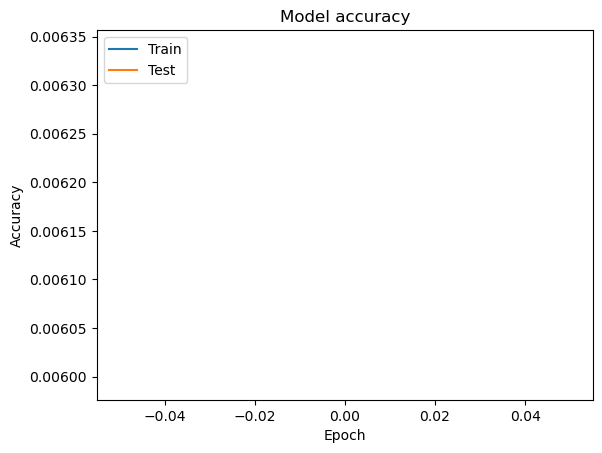

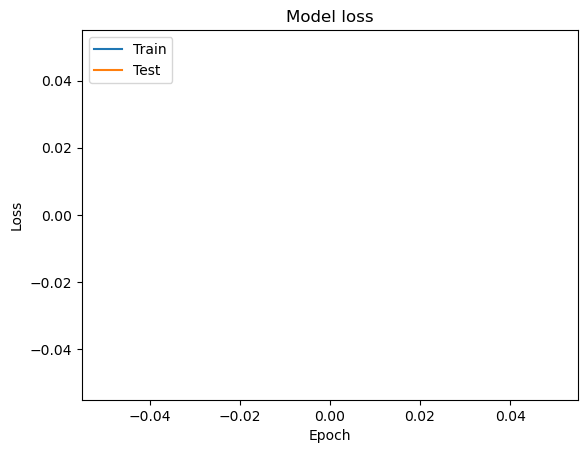

In [26]:
# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Step 3 - Prediction

In [27]:
debug.msg_debug("################################################################")
debug.msg_debug(" Make a prediction and store the results.")
debug.msg_debug("################################################################")
debug.msg_debug("")
#storage for predicted output
y_hat=[]

#given the 20% reserved, apply those data points to the model to get a prediction for Y (outputs)
debug.msg_debug(" ...model.predict()")
y_hat.append(models[-1].predict(x_test[-1]))

[2022-12-14 21:54:54 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:54:54 UTC]   DEBUG:  Make a prediction and store the results. 
[2022-12-14 21:54:54 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:54:54 UTC]   DEBUG:  
[2022-12-14 21:54:54 UTC]   DEBUG:  ...model.predict() 


In [28]:
debug.msg_debug("")
debug.msg_debug("################################################################")
debug.msg_debug(" Data Peek")
debug.msg_debug("################################################################")
debug.msg_debug("...your y_hat (output prediction) should have the same number of columns as your y_test (output)")
debug.msg_debug("          y_hat shape: " + str(y_hat[-1].shape))
debug.msg_debug("         y_test shape: " + str(y_test[-1].shape))
debug.msg_debug("         x_test shape: " + str(x_test[-1].shape))
debug.msg_debug("...your y and x arrays (columns) should equal to the total domain of variables:")
debug.msg_debug("variable_domain shape: " + str(len(ACS_SCALED_DOMAIN)))

[2022-12-14 21:54:55 UTC]   DEBUG:  
[2022-12-14 21:54:55 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:54:55 UTC]   DEBUG:  Data Peek 
[2022-12-14 21:54:55 UTC]   DEBUG: ################################################################ 
[2022-12-14 21:54:55 UTC]   DEBUG: ...your y_hat (output prediction) should have the same number of columns as your y_test (output) 
[2022-12-14 21:54:55 UTC]   DEBUG:           y_hat shape: (10845, 1) 
[2022-12-14 21:54:55 UTC]   DEBUG:          y_test shape: (10845, 1) 
[2022-12-14 21:54:55 UTC]   DEBUG:          x_test shape: (10845, 35) 
[2022-12-14 21:54:55 UTC]   DEBUG: ...your y and x arrays (columns) should equal to the total domain of variables: 
[2022-12-14 21:54:55 UTC]   DEBUG: variable_domain shape: 36 


In [29]:
debug.msg_debug("...x_test shape and data")
#a=x_test[-1][:,:]
a=x_test[-1]
debug.msg_debug(str(a.shape))
debug.msg_debug(a)
debug.msg_debug("")

debug.msg_debug("...y_hat (prediction) shape and data")
a=y_hat[-1]
debug.msg_debug(str(a.shape))
debug.msg_debug(a)
debug.msg_debug("")

debug.msg_debug("...x_test and y_hat arrays should have different columns but the same number of rows (records)")

[2022-12-14 21:54:55 UTC]   DEBUG: ...x_test shape and data 
[2022-12-14 21:54:55 UTC]   DEBUG: (10845, 35) 
[2022-12-14 21:54:55 UTC]   DEBUG:        Temp(C)  Cond(S/m)  Sal(PSU)  a650__  a676__  a715__  c510__  c532__  \
14580   0.9657     0.9093    0.8871  0.0313  0.0339  0.1484  0.0761  0.0695   
48776   0.8129     0.8153    0.8139  0.1290  0.1434  0.2352  0.2084  0.1983   
38845   0.9021     0.9997    0.9997  0.4255  0.4355  0.5040  0.5346  0.5200   
41874   0.9117     0.8255    0.8068  0.2109  0.2261  0.3067  0.3055  0.2939   
19898   0.9854     0.8970    0.8699  0.0213  0.0262  0.1385  0.0525  0.0474   
...        ...        ...       ...     ...     ...     ...     ...     ...   
41598   0.9115     0.8267    0.8082  0.2209  0.2389  0.3109  0.3234  0.3116   
2793    0.8829     0.7638    0.7455  0.0227  0.0202  0.1392  0.0623  0.0556   
17016   0.9786     0.8982    0.8726  0.0218  0.0223  0.1436  0.0575  0.0516   
35850   0.9089     0.8283    0.8104  0.5901  0.5985  0.6492  0.814

## But why are the numbers so weird?

Remember that you scaled the data between 1 and 0 which means your prediction is scaled at the same level.

We now need to set the values back to what they were along with the prediction.

In [30]:
#######################################################################
# Invert the scaling you did previously
# inverse the scaling so you get meaningful numbers back from your predicted data
#######################################################################   

#df = pd.DataFrame(scaler.inverse_transform(np.column_stack((x_test[:,:2], y_hat[:,:2], x_test[:,2], y_hat[:,2:]))),columns=['lat', 'lon', 'SSH', 'Salinity', 'Temperature', 'U3D', 'V3D', 'sphy', 'diatoms', 'mezoo', 'mizoo'])
#df_truth = pd.DataFrame(scaler.inverse_transform(np.column_stack((x_test[:,:2], y_test[:,:2], x_test[:,2], y_test[:,2:]))),columns=['lat', 'lon', 'SSH', 'Salinity', 'Temperature', 'U3D', 'V3D', 'sphy', 'diatoms', 'mezoo', 'mizoo'])

#break the data out in calculated (predicted) and truth (actual values), this will make comparison wrt accuracy easier
df_calc=[]
df_truth=[]

#Stack the columns side by side between the two datasets, then using the same scaler perform an inverse of the transformation
#that set everything between 0 and 1.
#df_calc.append (pd.DataFrame(scaler.inverse_transform(np.column_stack((x_test[-1][:,:], y_hat[-1][:,:]))),
#                  columns=ACS_SCALED_DOMAIN))
df_calc.append (pd.DataFrame(scaler.inverse_transform(np.column_stack((x_test[-1], y_hat[-1]))),
                  columns=ACS_SCALED_DOMAIN))

#df_truth.append(pd.DataFrame(scaler.inverse_transform(np.column_stack((x_test[-1][:,:], y_test[-1][:,:]))),
#                  columns=ACS_SCALED_DOMAIN))
df_truth.append (pd.DataFrame(scaler.inverse_transform(np.column_stack((x_test[-1], y_test[-1]))),
                  columns=ACS_SCALED_DOMAIN))


In [31]:
# let's look at some sample output for df_truth (you should now see values you expect)
df_truth[-1]

,Temp(C),Cond(S/m),Sal(PSU),a650__,a676__,a715__,c510__,c532__,c555__,a412__,...,BetaP(532),bbP(532),bb(532),Beta(650),BetaP(650),bbP(650),bb(650),CHL(ug/l),PE(ppb),CDOM(ppb)
0,21.0271,3.6385,25.1350,0.5301,0.6694,1.1268,4.2549,4.0372,3.8747,1.4695,...,0.0076,0.0524,0.0536,0.0076,0.0076,0.0524,0.0529,0.0000,7.6475,14.0000
1,19.5549,3.2630,23.0676,0.7606,0.9093,1.2960,9.1136,8.7391,8.3878,2.5182,...,0.0151,0.1047,0.1058,0.0134,0.0133,0.0919,0.0924,0.0130,10.7065,15.5000
2,20.4138,3.9992,28.3198,1.4599,1.5494,1.8203,21.1010,20.4857,19.9853,4.7426,...,0.0514,0.3551,0.3562,0.0134,0.0133,0.0919,0.0924,0.0910,11.2309,16.7500
3,20.5067,3.3037,22.8654,0.9536,1.0904,1.4356,12.6822,12.2320,11.7781,3.2128,...,0.0248,0.1717,0.1729,0.0134,0.0133,0.0919,0.0924,0.0780,12.1923,18.2500
4,21.2167,3.5893,24.6497,0.5065,0.6526,1.1074,3.3851,3.2328,3.1050,1.4047,...,0.0063,0.0436,0.0448,0.0066,0.0066,0.0455,0.0460,-0.0260,7.2542,11.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,20.5050,3.3088,22.9055,0.9772,1.1185,1.4437,13.3423,12.8756,12.4497,3.2900,...,0.0242,0.1676,0.1687,0.0134,0.0133,0.0919,0.0924,0.1170,12.3671,18.2500
10841,20.2290,3.0576,21.1318,0.5099,0.6395,1.1088,3.7457,3.5293,3.3745,1.5501,...,0.0063,0.0438,0.0449,0.0058,0.0058,0.0399,0.0404,0.0260,6.5550,12.5000
10842,21.1513,3.5943,24.7249,0.5076,0.6440,1.1173,3.5697,3.3829,3.2308,1.4361,...,0.0065,0.0448,0.0459,0.0063,0.0062,0.0429,0.0433,0.0390,6.8609,12.0000
10843,20.4799,3.3151,22.9675,1.8480,1.9063,2.1036,31.3936,30.5746,29.5433,6.8530,...,0.0575,0.3977,0.3988,0.0134,0.0133,0.0919,0.0924,0.1170,14.0714,27.5000


## Look at the differences

In [32]:
#######################################################################
# compute the error between everything except the inputs. 
# The inputs will be 0.0 since they're not predictions.
#######################################################################   
df_diff=[]
df_diff.append(pd.DataFrame(scaler.inverse_transform(np.column_stack((x_test[-1], y_hat[-1]))) - 
                            scaler.inverse_transform(np.column_stack((x_test[-1], y_test[-1]))),
                            columns=ACS_SCALED_DOMAIN) )

In [33]:
# look at the results
debug.msg_debug("Lat,lon,A's and Temp should all be zero.")
debug.msg_debug("All Beam Absorption should be the delta between truth and prediction.")
debug.msg_debug("Only the CDOM(ppb), output variable should have a value.")
df_diff[-1]

[2022-12-14 21:54:58 UTC]   DEBUG: Lat,lon,A's and Temp should all be zero. 
[2022-12-14 21:54:58 UTC]   DEBUG: All Beam Absorption should be the delta between truth and prediction. 
[2022-12-14 21:54:58 UTC]   DEBUG: Only the CDOM(ppb), output variable should have a value. 


,Temp(C),Cond(S/m),Sal(PSU),a650__,a676__,a715__,c510__,c532__,c555__,a412__,...,BetaP(532),bbP(532),bb(532),Beta(650),BetaP(650),bbP(650),bb(650),CHL(ug/l),PE(ppb),CDOM(ppb)
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
10841,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
10842,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
10843,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN


## Show Results (graphically)

Plot the number of iterations against the Mean Absolute Error (MAE) and Mean Squared Error (MSE).

In statistics, mean absolute error (MAE) is a measure of difference between two continuous variables. Assume X and Y are variables of paired observations that express the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. Consider a scatter plot of n points, where point i has coordinates (xi, yi)... Mean Absolute Error (MAE) is the average vertical distance between each point and the identity line. MAE is also the average horizontal distance between each point and the identity line. 

In statistics, the mean squared error (MSE) or mean squared deviation (MSD) of an estimator (of a procedure for estimating an unobserved quantity) measures the average of the squares of the errors—that is, the average squared difference between the estimated values and what is estimated. MSE is a risk function, corresponding to the expected value of the squared error loss. The fact that MSE is almost always strictly positive (and not zero) is because of randomness or because the estimator does not account for information that could produce a more accurate estimate.[1]

The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.

The MSE is the second moment (about the origin) of the error, and thus incorporates both the variance of the estimator (how widely spread the estimates are from one data sample to another) and its bias (how far off the average estimated value is from the truth). For an unbiased estimator, the MSE is the variance of the estimator. Like the variance, MSE has the same units of measurement as the square of the quantity being estimated. In an analogy to standard deviation, taking the square root of MSE yields the root-mean-square error or root-mean-square deviation (RMSE or RMSD), which has the same units as the quantity being estimated; for an unbiased estimator, the RMSE is the square root of the variance, known as the standard error. 


Train Loss: Value of the objective function you are minimizing. This value could be a positive or negative number, depending on the specific objective function.

Train Error: Human interpretable metric of your model's performance. Usually means what % of training examples the model got incorrect. This is always a value between 0 and 1.

Loss

A measure of how far a model's predictions are from its label. Or, to phrase it more pessimistically, a measure of how bad the model is. To determine this value, a model must define a loss function. For example, linear regression models typically use mean squared error for a loss function, while logistic regression models use Log Loss.

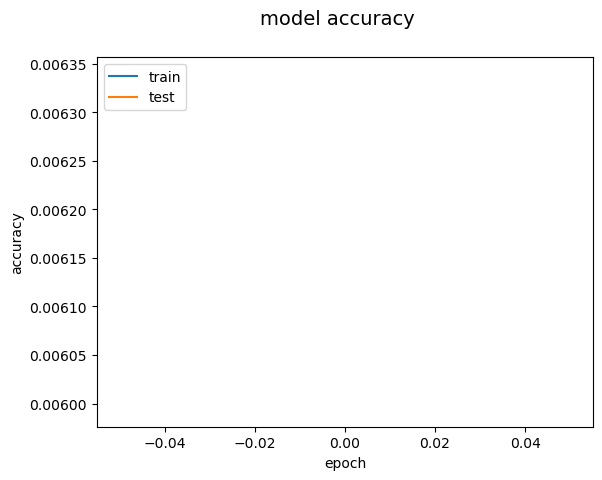

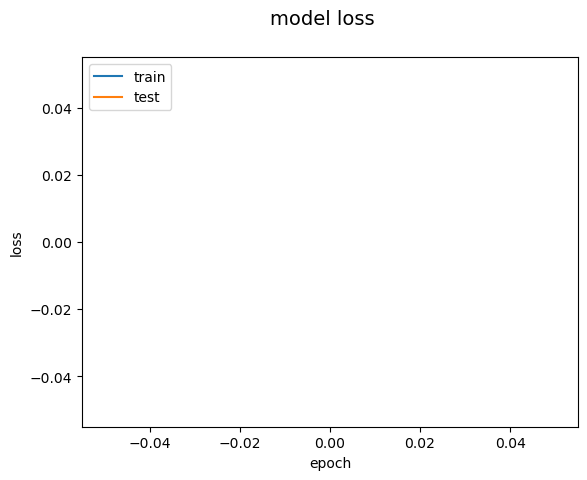

In [34]:
import matplotlib.pyplot as plt

def plot_history(history):

  hist = pd.DataFrame(history.history)
  fig=plt.figure()
  fig.suptitle('model accuracy', fontsize=14)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  #plt.savefig("./"+PROJECT_OUTPUT+"_"+str(ACTIVE_MONTH)+"_depth_" + str(daDepth) + "_LossVsEpoch.png")    
  plt.close()
    
  # summarize history for loss
  fig=plt.figure()
  fig.suptitle('model loss', fontsize=14)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()    
  #plt.savefig("./"+PROJECT_OUTPUT+"_"+str(ACTIVE_MONTH)+"_depth_" + str(daDepth) + "_AccuracyVsEpoch.png")
  plt.close()

current_history = model_history
plot_history(current_history)

## Show Test versus Trained results (graphically)
Plot the original 20% of data pulled from the training set against the predicted values from the model / predictor.

Processing c510__


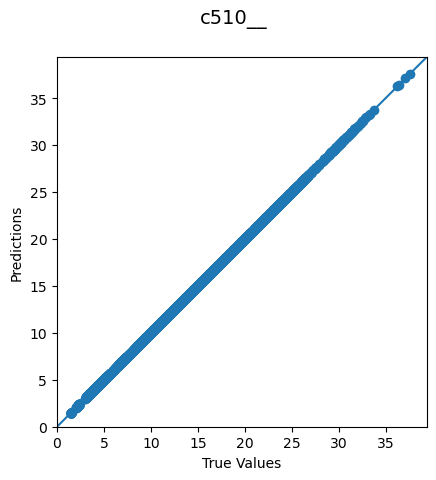

Processing c532__


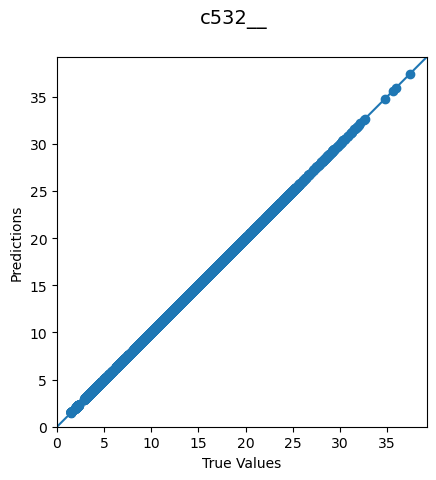

Processing c555__


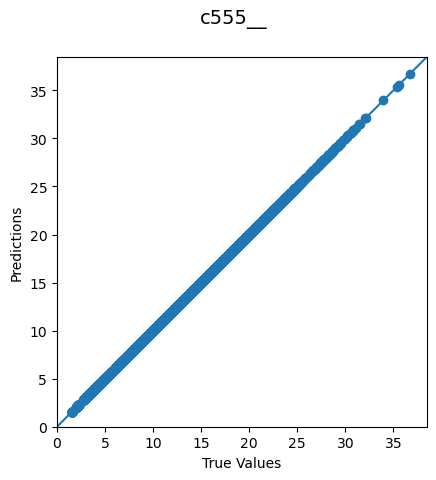

Processing c650__


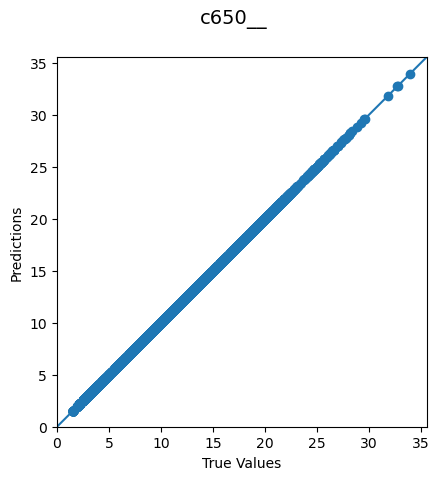

Processing c676__


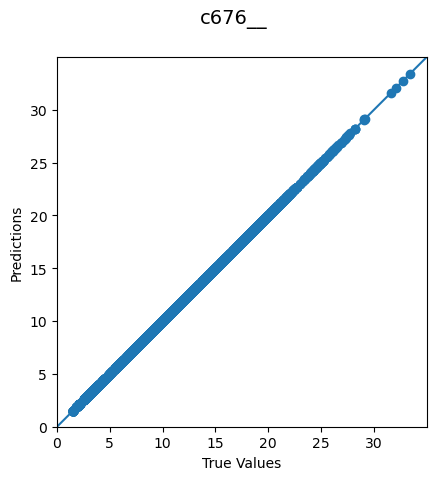

Processing c715__


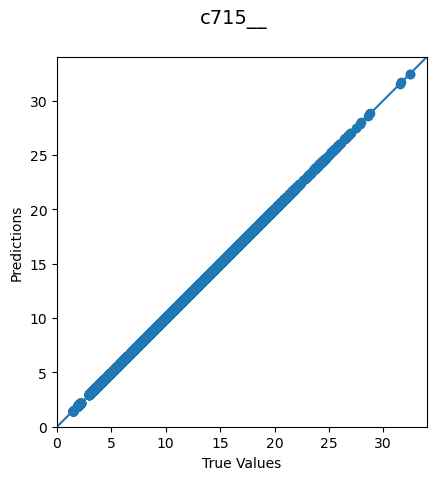

Processing c412__


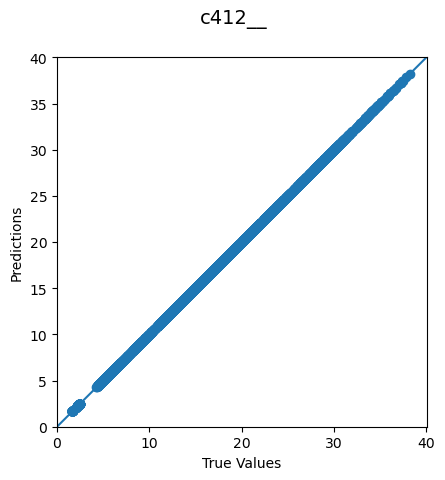

Processing c440__


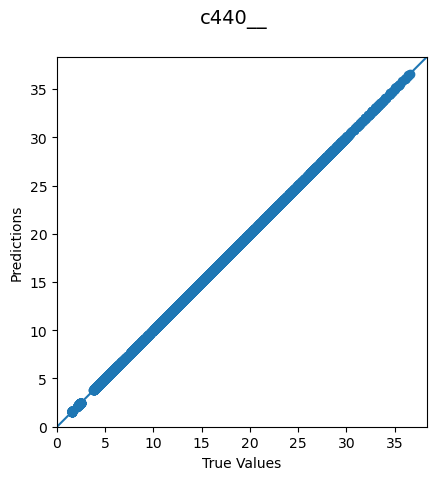

Processing c488__


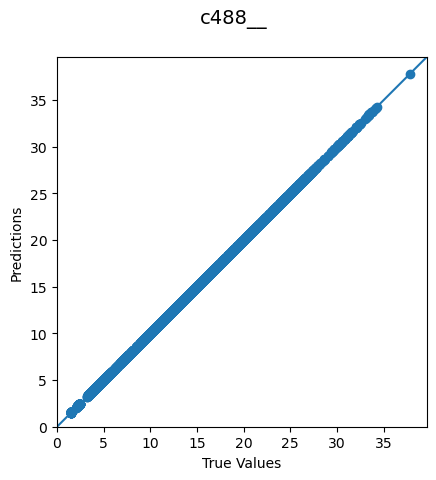

In [35]:
#test_predictions = model.predict(normed_test_data).flatten()
plt_var_domain=["c510__","c532__","c555__","c650__","c676__","c715__","c412__","c440__","c488__"]

for col_name in plt_var_domain:  
    print("Processing " + str(col_name))
    x_plot = df_calc[-1][col_name]
    y_plot = df_truth[-1][col_name]
    fig=plt.figure()
    fig.suptitle(str(col_name), fontsize=14)
    plt.scatter(x_plot, y_plot)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()
    #plt.savefig("./"+PROJECT_OUTPUT+"_"+str(ACTIVE_MONTH)+"_depth_"+ str(daDepth) + "_" + str(col_name) + "_PredVsTest.png")
    plt.close()

## Display accuracy of prediction
This histogram shows the prediction made minus the test labels (20% pulled from the original dataset).
The results should be as close to zero as possible.

Processing c510__


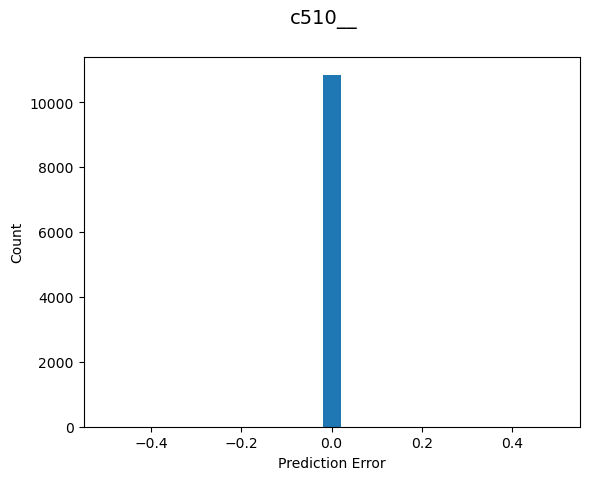

Processing c532__


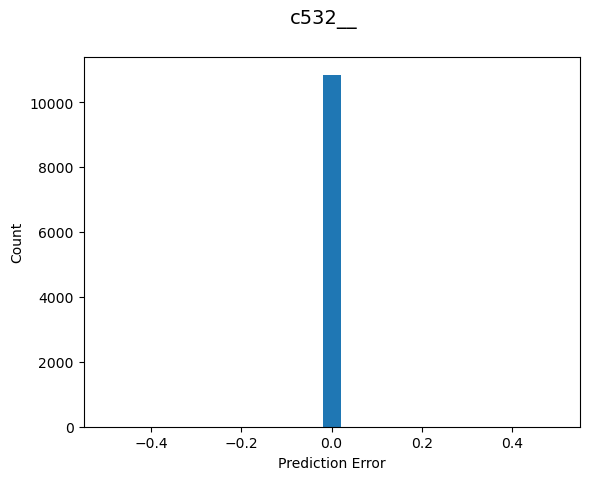

Processing c555__


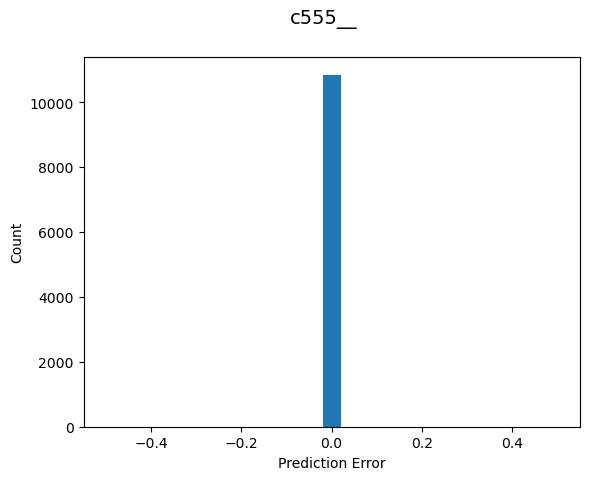

Processing c650__


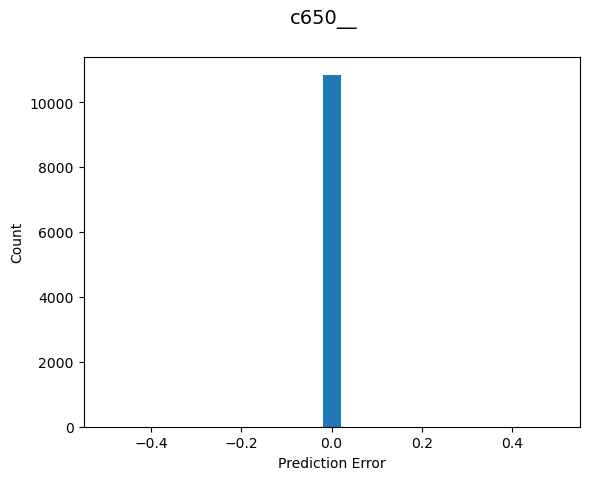

Processing c676__


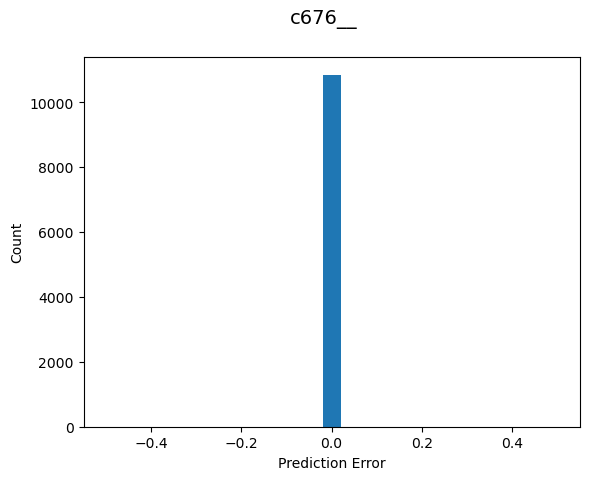

Processing c715__


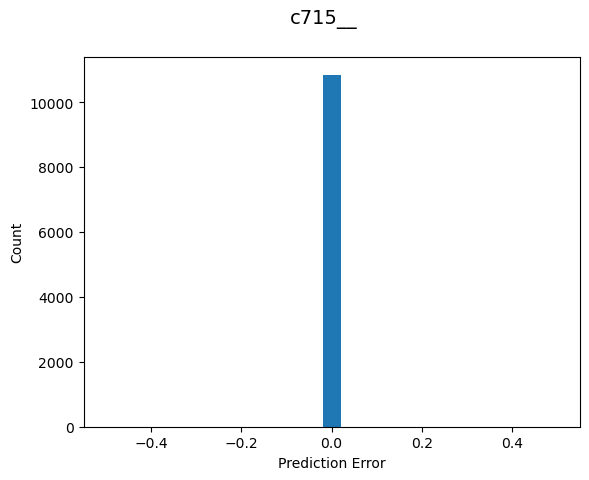

Processing c412__


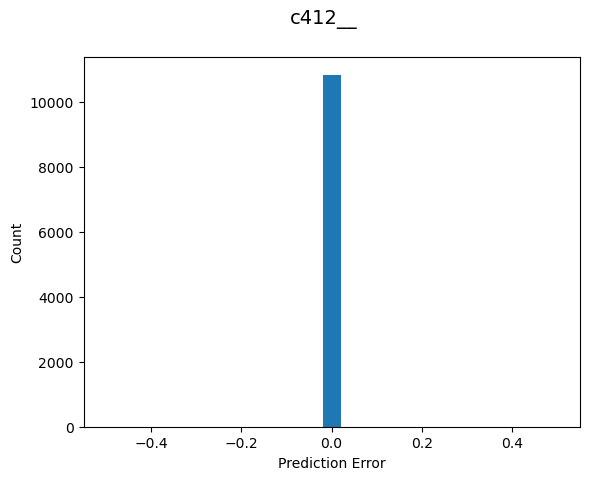

Processing c440__


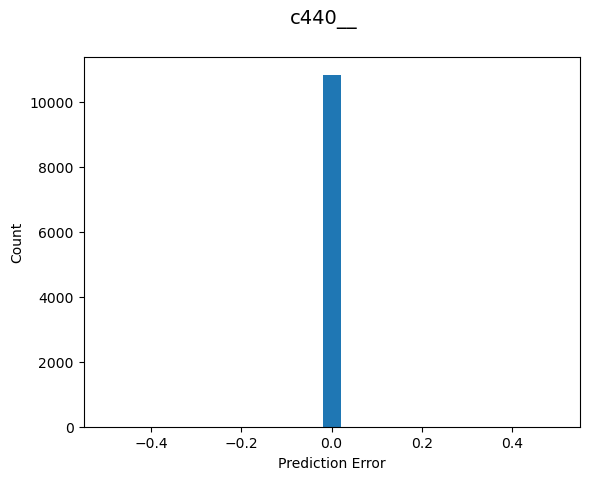

Processing c488__


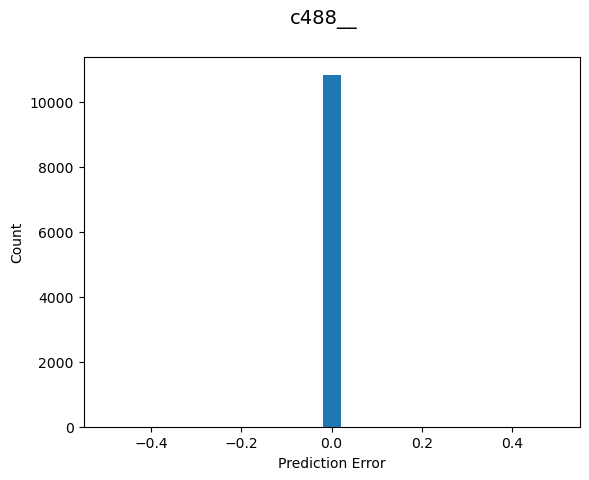

In [36]:
plt_x_min = -0.1
plt_x_max =  0.1

for col_name in plt_var_domain:  
    print("Processing " + str(col_name))
    fig=plt.figure()
    fig.suptitle(str(col_name), fontsize=14)
    plt.hist(df_diff[-1][col_name], bins = 25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    plt.show()
    #plt.savefig("./"+PROJECT_OUTPUT+"_"+str(ACTIVE_MONTH)+"_depth_"+str(daDepth) + "_" + str(col_name) + "_Histogram.png")
    plt.close()